# 使用 PyTorch 构建卷积神经网络


### 导入必要的库


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## MNIST 数字分类


为了展示二维卷积神经网络的高效性，我们将从经典的 MNIST 数据集（0-9 数字分类）开始。本示例将复用之前笔记本中的代码，特别是全连接网络的部分。


### 获取数据集并创建训练数据加载器


In [2]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

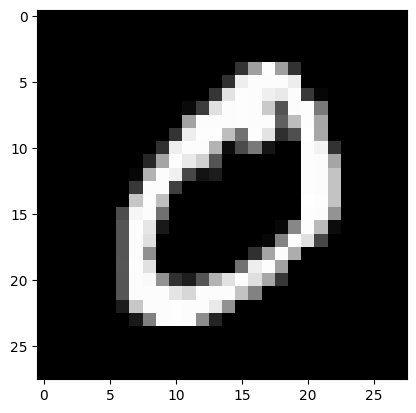

Le chiffre sur l'image est un 0


In [3]:
plt.imshow(dataset[1][0].permute(1,2,0).numpy(), cmap='gray')
plt.show()
print("Le chiffre sur l'image est un "+str(dataset[1][1]))

In [4]:
train_dataset, validation_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### 使用 PyTorch 构建卷积神经网络


In [5]:
class cnn(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.conv1=nn.Conv2d(1,8,kernel_size=3,padding=1) # Couche de convolution de 8 filtres
    self.conv2=nn.Conv2d(8,16,kernel_size=3,padding=1) # Couche de convolution de 16 filtres
    self.conv3=nn.Conv2d(16,32,kernel_size=3,padding=1) # Couche de convolution de 32 filtres
    self.pool1=nn.MaxPool2d((2,2)) # Couche de max pooling 
    self.pool2=nn.MaxPool2d((2,2))
    self.fc=nn.Linear(32*7*7,10)
  
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=self.pool1(x)
    x=F.relu(self.conv2(x))
    x=self.pool2(x)
    x=F.relu(self.conv3(x))
    x=x.view(-1,32*7*7) # Pour convertir la feature map de taille 32x7x7 en taille vecteur de taille 1568
    output=self.fc(x)
    return output

In [6]:
model = cnn()
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

cnn(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)
Nombre de paramètres 21578


可以看到，该模型的参数数量远少于传统的全连接网络。


### 模型训练


定义损失函数和训练超参数：


In [7]:
criterion = nn.CrossEntropyLoss()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

现在开始训练模型：


In [8]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.318773478269577
step 0 val loss 0.08984239399433136
step 1 train loss 0.08383051306009293
step 1 val loss 0.0710655003786087
step 2 train loss 0.05604167655110359
step 2 val loss 0.0528845489025116
step 3 train loss 0.04518255963921547
step 3 val loss 0.051780227571725845
step 4 train loss 0.03614392504096031
step 4 val loss 0.0416230633854866


计算测试集上的准确率：


In [9]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  98.64


可以看到，该模型在测试集上的准确率约为 99%，而参数数量是其 10 倍的全连接网络准确率仅为 97.5%。


### Softmax 与结果解释


当模型对某个样本进行预测时，会输出形如以下的向量：


In [10]:
images,labels=next(iter(test_loader))

#Isolons un élément 
image,label=images[0].unsqueeze(0),labels[0].unsqueeze(0) # Le unsqueeze permet de garder la dimension batch
pred=model(image)
print(pred)

tensor([[ -9.6179,  -5.1802,  -2.6094,   0.9121, -16.0603,  -8.6510, -30.0099,
          14.4031,  -9.0074,  -2.0431]], grad_fn=<AddmmBackward0>)


仔细观察结果，可以发现第 7 个元素的值最大，这意味着模型预测为 **3**（索引从 0 开始）。
验证其真实标签：


In [11]:
print(label)

tensor([7])


真实标签为 **7**。不过，我们更希望得到**类别概率**，这样更直观，也更容易理解模型的置信度。


为此，我们使用 **softmax 激活函数**。

其定义如下：
$\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$，其中 $K$ 是模型的类别数。

该函数被称为 *softmax*，因为它能放大最大值，同时压缩其他值，从而得到一个概率分布（所有 $K$ 个类别的值之和为 1）。


In [12]:
print(F.softmax(pred))

tensor([[3.6964e-11, 3.1266e-09, 4.0884e-08, 1.3833e-06, 5.8867e-14, 9.7215e-11,
         5.1481e-20, 1.0000e+00, 6.8068e-11, 7.2027e-08]],
       grad_fn=<SoftmaxBackward0>)


/tmp/ipykernel_232253/3904022211.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(pred))


现在输出的值为概率，可以看到模型以 **99.9%** 的置信度预测为 **7**，说明模型对该预测非常有信心。


### 其他应用


卷积神经网络在**图像处理**领域表现尤为出色，同时也广泛应用于**音频处理**和**视频处理**等领域。


本课程后续的笔记本将展示卷积神经网络在比 MNIST 更复杂的任务中的应用。建议使用 **GPU** 或在 **Google Colab** 上运行笔记本，以获得合理的训练时间（不过，即使不训练模型，也可以继续学习课程内容）。
